## Import utilities

In [17]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms  
import torchvision
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import pandas as pd
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

from pathlib import Path
import glob
from PIL import Image

In [18]:
data_dir_Train = "datasets/cust_12"
data_dir_Test = data_dir_Train

train_dir = data_dir_Train + "/train"
valid_dir = "datasets/cust_8_real" + "/test"

outcomes = os.listdir(train_dir)
mix = False
max_synth = -1

data_dir_real = "datasets/cust_8_real/train"

In [19]:
# printing the all outcomes
print(outcomes)

['images', 'labels']


---

## Dataset class

In [20]:
class OrientationDataset(Dataset):
    def __init__(self, base_folder, transform=None, max=-1):
        self.img_labels_path = Path(base_folder) / "labels"
        self.imgs = glob.glob(base_folder + "/images/*.png")[:max]
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img_name = os.path.basename(img_path)[:-4]
        image = Image.open(img_path).convert('RGB')
        label = 0
        with open(str(self.img_labels_path / f"{img_name}.txt"), "r") as f:
            label = int(float(f.readline().split()[1]))
        
        if self.transform:
            image = self.transform(image)
        return image, label
    
class OrientationMixDataset(Dataset):
    def __init__(self, base_folder, real_folder, transform=None, max=-1):
        synth_imgs = glob.glob(base_folder + "/images/*.png")[:max]
        real_imgs = glob.glob(real_folder + "/images/*.png")
        self.imgs = synth_imgs + real_imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img_name = os.path.basename(img_path)[:-4]
        image = Image.open(img_path).convert('RGB')
        label = 0
        label_path = Path(img_path).parents[1] / "labels"
        with open(str(label_path / f"{img_name}.txt"), "r") as f:
            label = int(float(f.readline().split()[1]))
        
        if self.transform:
            image = self.transform(image)
        return image, label




#### Early Stopping class

In [21]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Augmentation

In [22]:

# convert data to a normalized torch.FloatTensor
transform = torchvision.transforms.Compose([
    transforms.Resize((80,80)),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205)),
    ])

# Augmentation on test images not needed
transform_tests = torchvision.transforms.Compose([
    transforms.Resize((80,80)),
    transforms.ToTensor(),
    # transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205)),    
    ])

# Augmentation on test images not needed
no_norm_transform_tests = torchvision.transforms.Compose([
    transforms.Resize((80,80)),
    transforms.ToTensor(),
    # transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))    
    ])

In [23]:
# ImageFloder function uses for make dataset by passing dir adderess as an argument
train_data = OrientationDataset(train_dir,transform=transform)
if mix:
    train_data = OrientationMixDataset(train_dir, data_dir_real, transform=transform, max=max_synth)
test_data = OrientationDataset(valid_dir,transform=transform_tests)
clean_data = OrientationDataset(valid_dir,transform=no_norm_transform_tests)

valid_size = 0.15
# Split data into train and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data,batch_size=500,sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size =100, sampler=valid_sampler)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)

In [24]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

device =  torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


---

# Using pretrained model.

In [25]:
import torchvision
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights

class DegreeCNN(nn.Module):
    def __init__(self):
        super(DegreeCNN, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in self.resnet.parameters():
            param.required_grad = False
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 360)

    def forward(self, x):
        x = self.resnet(x)
        return x  # No need to apply softmax here if using CrossEntropyLoss

class DegreeCNN50(nn.Module):
    def __init__(self):
        super(DegreeCNN50, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        for param in self.resnet.parameters():
            param.required_grad = False
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 360)

    def forward(self, x):
        x = self.resnet(x)
        return x  # No need to apply softmax here if using CrossEntropyLoss

model = DegreeCNN().to(device)
# if fine-tuning
# model.load_state_dict(torch.load('checkpoint_pretra.pt'))

----

In [26]:
# Specify loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6], gamma=0.06)

# Train model

In [27]:
def train_model_func(name, train_loader, valid_loader, model_state=None, use_50=False):
    if os.path.exists(f'{name}.pt'):
        return 0,0
    
    model = DegreeCNN().to(device) if not use_50 else DegreeCNN50().to(device)
    if model_state:
        model.load_state_dict(torch.load(f'{model_state}.pt'))
    criterion = nn.CrossEntropyLoss()

    # specify optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # number of epochs for training set
    epochs = 100

    # track change in validation loss
    val_loss = []
    tn_loss = []

    early_stopping = EarlyStopping(patience=4, verbose=True, path=f'{name}.pt')

    for epoch in range(1,epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # Train the model
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move tensor to gpu if cuda is available
            if train_on_gpu:
                data, target = data.to(device), target.to(device)
            # clear the gradiant of all optimizer variable
            optimizer.zero_grad()
            # forward pass: compute pradictions by passing inputs
            output = model(data)
            # calculate batch loss
            loss = criterion(output, target)
            # backward pass: compute gradiant of the loss with respect to the parameters
            loss.backward()
            # update parameters by optimizing single step
            optimizer.step()
            
            # update training loss
            train_loss += loss.item()*data.size(0)

        # validate the model

        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move tensor to gpu
            if train_on_gpu:
                data, target = data.to(device), target.to(device)
            # forward pass: compute the validation predictions
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update the validation loss 
            valid_loss += loss.item()*data.size(0)
        
        # calculate average loss
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        val_loss.append(valid_loss)
        tn_loss.append(train_loss)

        # Print the train and validation loss statistic
        print('Epoch: {} \t Training Loss: {:.3f} \t Validation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return tn_loss, val_loss


In [28]:
# train mixed

maxes = [1000, 2000, 3000, 4000, 5000, 8000, 10000, 12500, 15000, 20000, 25000]
for i in range(3):
    for max_synth in maxes:
        # ImageFloder function uses for make dataset by passing dir adderess as an argument
        train_data = OrientationMixDataset(train_dir, data_dir_real, transform=transform, max=max_synth)

        valid_size = 0.15
        # Split data into train and validation set
        num_train = len(train_data)
        indices = list(range(num_train))
        np.random.shuffle(indices)
        split = int(np.floor(valid_size * num_train))
        train_idx, valid_idx = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data,batch_size=500,sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size =100, sampler=valid_sampler)

        if i == 0:
            train_model_func(f"weights/weight_{max_synth}", train_loader, valid_loader)
        else:
            train_model_func(f"weights/weight_{max_synth}_v{i+1}", train_loader, valid_loader)
        

In [29]:
# train fine-tuned
for max_synth in maxes:
    train_data = OrientationDataset(train_dir, transform=transform, max=max_synth)
    valid_size = 0.15
    # Split data into train and validation set
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_data,batch_size=500,sampler=train_sampler)
    valid_loader = DataLoader(train_data, batch_size =100, sampler=valid_sampler)



    train_model_func(f"weights/checkpoint_{max_synth}", train_loader, valid_loader)

    train_data = OrientationDataset(data_dir_real, transform=transform)
    valid_size = 0.15
    # Split data into train and validation set
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_data,batch_size=500,sampler=train_sampler)
    valid_loader = DataLoader(train_data, batch_size =100, sampler=valid_sampler)
    train_model_func(f"weights/fine_{max_synth}", train_loader, valid_loader, model_state=f"weights/checkpoint_{max_synth}")

----

# Plot graph between training loss and validation loss

In [30]:
# plt.plot(tn_loss, label='Training loss')
# plt.plot(val_loss, label='Validation loss')
# plt.legend(frameon=False)


# plt.show()



# Eval func

In [31]:
def evaluate_model(model, test_loader, limit=0):
    # Initialize counts and lists to store misclassified images and labels
    correct_count, all_count = 0, 0
    misclassified_images = []
    misclassified_pred_labels = []
    misclassified_true_labels = []
    errors = []
    flips = 0
    model.eval()
    for images, labels in test_loader:
        for i in range(len(labels)):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            img = images[i].view(1,3,80,80)
            with torch.no_grad():
                logps = model(img)
                
            ps = torch.exp(logps)
            probab = list(ps.cpu()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.cpu()[i]
            # If misclassified, store the image and labels
            error = min(abs(true_label - pred_label), abs(360-true_label - pred_label))
            if error > 130:
                flips += 1
            else:
                errors.append(error)

            is_true = error <= limit
            if not is_true:
                # misclassified_images.append(clean_data[all_count][0].cpu())  # store the image (on CPU)
                misclassified_images.append(images[i].cpu())  # store the image (on CPU)
                misclassified_pred_labels.append(pred_label)
                misclassified_true_labels.append(true_label)

            if is_true:
                correct_count += 1
            all_count += 1
 
    # print("Number of images Tested=", all_count)
    print("Model Accuracy=",(correct_count/all_count)*100, f" | avg error:{sum(errors)/len(errors)} | flips: {flips} \n ")
    return (correct_count/all_count)*100, sum(errors)/len(errors), flips

----

# Predictions on test dataset

In [32]:
import matplotlib.pyplot as plt

def plot_misclassified_images(misclassified_images, misclassified_true_labels, misclassified_pred_labels):
    for index in range(len(misclassified_images)):
        plt.imshow(misclassified_images[index].permute(1, 2, 0))  # Convert tensor to image
        plt.title(f"True: {misclassified_true_labels[index]}, Pred: {misclassified_pred_labels[index]}")
        plt.show()

def plot_misclassified_images_grid(misclassified_images, misclassified_true_labels, misclassified_pred_labels, rows=2, cols=3):
    total_images = len(misclassified_images)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < total_images:
            ax.imshow(torch.clip(misclassified_images[i].permute(1, 2, 0), 0, 1))  # Convert tensor to image
            ax.set_title(f"True: {misclassified_true_labels[i]}, Pred: {misclassified_pred_labels[i]}")
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide empty subplots if images are fewer than grid spaces

    plt.tight_layout()
    plt.show()


mix_data = [(0,0,0) for i in range(len(maxes))]

for i in range(3):
    for idx, max_synth in enumerate(maxes):
        # Load model state dict
        model = DegreeCNN().to(device)
        if i == 0:
            model.load_state_dict(torch.load(f"weights/weight_{max_synth}.pt"))
        else:
            model.load_state_dict(torch.load(f"weights/weight_{max_synth}_v{i+1}.pt"))
        model.eval()
        model.cuda()
        acc, err, flip = evaluate_model(model, test_loader)
        print(f"{max_synth}: {acc, err, flip}")
        new_tuple = (mix_data[idx][0] + acc/3, mix_data[idx][1] + err/3, mix_data[idx][2] + flip/3)
        mix_data[idx] = new_tuple


    # plot_misclassified_images_grid(misclassified_images, misclassified_true_labels, misclassified_pred_labels, rows=10, cols=3)



# Display misclassified images in a grid with specified rows and columns
# 

# Display misclassified images
# plot_misclassified_images(misclassified_images, misclassified_true_labels, misclassified_pred_labels)
# 

C:\Users\Aviv\AppData\Local\Temp\ipykernel_9228\2998030025.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"weights/weight_{max_synth}

Model Accuracy= 9.795918367346939  | avg error:4.714285850524902 | flips: 0 
 
1000: (9.795918367346939, tensor(4.7143), 0)
Model Accuracy= 8.16326530612245  | avg error:4.967347145080566 | flips: 0 
 
2000: (8.16326530612245, tensor(4.9673), 0)
Model Accuracy= 7.755102040816326  | avg error:4.297959327697754 | flips: 0 
 
3000: (7.755102040816326, tensor(4.2980), 0)
Model Accuracy= 7.755102040816326  | avg error:4.261224269866943 | flips: 0 
 
4000: (7.755102040816326, tensor(4.2612), 0)
Model Accuracy= 10.204081632653061  | avg error:3.8938775062561035 | flips: 0 
 
5000: (10.204081632653061, tensor(3.8939), 0)
Model Accuracy= 12.244897959183673  | avg error:3.097959280014038 | flips: 0 
 
8000: (12.244897959183673, tensor(3.0980), 0)
Model Accuracy= 9.387755102040817  | avg error:3.326530694961548 | flips: 0 
 
10000: (9.387755102040817, tensor(3.3265), 0)
Model Accuracy= 12.244897959183673  | avg error:2.448979616165161 | flips: 0 
 
12500: (12.244897959183673, tensor(2.4490), 0)
M

C:\Users\Aviv\AppData\Local\Temp\ipykernel_9228\2998030025.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"weights/weight_{max_synth}

Model Accuracy= 7.755102040816326  | avg error:4.4571428298950195 | flips: 0 
 
1000: (7.755102040816326, tensor(4.4571), 0)
Model Accuracy= 8.979591836734693  | avg error:4.897541046142578 | flips: 1 
 
2000: (8.979591836734693, tensor(4.8975), 1)
Model Accuracy= 4.8979591836734695  | avg error:5.008403301239014 | flips: 7 
 
3000: (4.8979591836734695, tensor(5.0084), 7)
Model Accuracy= 8.571428571428571  | avg error:5.146938800811768 | flips: 0 
 
4000: (8.571428571428571, tensor(5.1469), 0)
Model Accuracy= 7.755102040816326  | avg error:3.7387754917144775 | flips: 0 
 
5000: (7.755102040816326, tensor(3.7388), 0)
Model Accuracy= 11.428571428571429  | avg error:3.181069850921631 | flips: 2 
 
8000: (11.428571428571429, tensor(3.1811), 2)
Model Accuracy= 9.795918367346939  | avg error:3.4040815830230713 | flips: 0 
 
10000: (9.795918367346939, tensor(3.4041), 0)
Model Accuracy= 14.69387755102041  | avg error:5.40408182144165 | flips: 0 
 
12500: (14.69387755102041, tensor(5.4041), 0)


In [33]:
fin_data = []
for max_synth in maxes:
    # Load model state dict
    model = DegreeCNN().to(device)
    model.load_state_dict(torch.load(f"weights/fine_{max_synth}.pt"))
    model.eval()
    model.cuda()
    result = evaluate_model(model, test_loader)
    print(f"{max_synth}: {result}")
    fin_data.append(result)

C:\Users\Aviv\AppData\Local\Temp\ipykernel_9228\3589939140.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"weights/fine_{max_synth}.pt

Model Accuracy= 5.3061224489795915  | avg error:6.893003940582275 | flips: 2 
 
1000: (5.3061224489795915, tensor(6.8930), 2)
Model Accuracy= 5.714285714285714  | avg error:15.415637969970703 | flips: 2 
 
2000: (5.714285714285714, tensor(15.4156), 2)
Model Accuracy= 9.387755102040817  | avg error:4.800000190734863 | flips: 0 
 
3000: (9.387755102040817, tensor(4.8000), 0)
Model Accuracy= 10.612244897959183  | avg error:3.7387754917144775 | flips: 0 
 
4000: (10.612244897959183, tensor(3.7388), 0)
Model Accuracy= 13.46938775510204  | avg error:3.522449016571045 | flips: 0 
 
5000: (13.46938775510204, tensor(3.5224), 0)
Model Accuracy= 13.877551020408163  | avg error:5.7265305519104 | flips: 0 
 
8000: (13.877551020408163, tensor(5.7265), 0)
Model Accuracy= 11.020408163265307  | avg error:2.763265371322632 | flips: 0 
 
10000: (11.020408163265307, tensor(2.7633), 0)
Model Accuracy= 12.653061224489795  | avg error:2.804081678390503 | flips: 0 
 
12500: (12.653061224489795, tensor(2.8041)

In [34]:
# train_model_func("checkpoint_real", train_loader, valid_loader)

weights = ["checkpoint_8_no_real", "checkpoint_real", "checkpoint_mix", "checkpoint_mixmix"]

for name in weights:
    # Load model state dict
    model.load_state_dict(torch.load(f"{name}.pt"))
    model.eval()
    model.cuda()
    # 
    # Initialize counts and lists to store misclassified images and labels
    correct_count, all_count = 0, 0
    misclassified_images = []
    misclassified_pred_labels = []
    misclassified_true_labels = []
    errors = []
    flips = 0
    model.eval()
    for images, labels in test_loader:
        for i in range(len(labels)):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            img = images[i].view(1,3,80,80)
            with torch.no_grad():
                logps = model(img)
                
            ps = torch.exp(logps)
            probab = list(ps.cpu()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.cpu()[i]
            # If misclassified, store the image and labels
            limit = 0
            error = min(abs(true_label - pred_label), abs(360-true_label - pred_label))
            if error > 130:
                flips += 1
            else:
                errors.append(error)

            is_true = error <= limit
            if not is_true:
                # misclassified_images.append(clean_data[all_count][0].cpu())  # store the image (on CPU)
                misclassified_images.append(images[i].cpu())  # store the image (on CPU)
                misclassified_pred_labels.append(pred_label)
                misclassified_true_labels.append(true_label)

            if is_true:
                correct_count += 1
            all_count += 1

    print(f"{name}:")        
    # print("Number of images Tested=", all_count)
    print("Model Accuracy=",(correct_count/all_count)*100, f" | avg error:{sum(errors)/len(errors)} | flips: {flips} \n ")

C:\Users\Aviv\AppData\Local\Temp\ipykernel_9228\3411207957.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{name}.pt"))


checkpoint_8_no_real:
Model Accuracy= 2.4489795918367347  | avg error:38.390625 | flips: 53 
 
checkpoint_real:
Model Accuracy= 4.8979591836734695  | avg error:14.460905075073242 | flips: 2 
 
checkpoint_mix:
Model Accuracy= 13.877551020408163  | avg error:3.391836643218994 | flips: 0 
 
checkpoint_mixmix:
Model Accuracy= 11.428571428571429  | avg error:3.057142972946167 | flips: 0 
 


# Test noise

In [35]:
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms

class LowerQualityTransform:
    def __init__(self, quality=20):
        """
        Initialize the transform with a specific quality.
        :param quality: JPEG quality (1 = lowest, 95 = highest).
        """
        self.quality = quality

    def __call__(self, image):
        """
        Apply the transform to an image.
        :param image: PIL Image to be transformed.
        :return: Transformed PIL Image with reduced quality.
        """
        buffer = BytesIO()
        image.save(buffer, format="JPEG", quality=self.quality)
        buffer.seek(0)
        return Image.open(buffer)
    
class AddNoiseTransform:
    def __init__(self, mean=0.0, std=0.1):
        """
        Initialize the transform with noise parameters.
        :param mean: Mean of the Gaussian noise.
        :param std: Standard deviation of the Gaussian noise.
        """
        self.mean = mean
        self.std = std

    def __call__(self, image):
        """
        Apply the noise to the image.
        :param image: Input image (PIL Image or Tensor).
        :return: Image with added noise.
        """
        # Convert PIL Image to Tensor if necessary
        if isinstance(image, torch.Tensor):
            image_tensor = image
        else:
            image_tensor = F.to_tensor(image)

        # Generate Gaussian noise
        noise = torch.randn_like(image_tensor) * self.std + self.mean

        # Add noise and clamp to valid range [0, 1]
        noisy_image = torch.clamp(image_tensor + noise, 0, 1)

        return noisy_image

In [ ]:
trainings = ["cust_9", "cust_10", "cust_11"]
names = ["textureless", "xo", "abc"]


for i, path in enumerate(trainings):
    train_dir = "datasets/" + path + "/train"
    train_data = OrientationDataset(train_dir, transform=transform)

    valid_size = 0.15
    # Split data into train and validation set
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_data,batch_size=500,sampler=train_sampler)
    valid_loader = DataLoader(train_data, batch_size =100, sampler=valid_sampler)
    train_model_func(f"weights/weight_{names[i]}", train_loader, valid_loader)

final_errs = []

for i, name in enumerate(names):
    model.load_state_dict(torch.load(f"weights/weight_{name}.pt"))
    model.eval()
    model.cuda()

    valid_dir = "datasets/" + trainings[i] + "/test"
    
    accs = []
    err = []
    all_flips = []
    qualities = [i * 0.1 for i in range(1, 30)]
    for sigma in qualities:

        blur_transform = torchvision.transforms.Compose([
    transforms.Resize((80,80)),
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(sigma, sigma)),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205)),    
    ])
        
        test_data = OrientationDataset(valid_dir,transform=blur_transform)
        test_loader= DataLoader(test_data,batch_size=32,shuffle=False)
        # Initialize counts and lists to store misclassified images and labels
        correct_count, all_count = 0, 0
        misclassified_images = []
        misclassified_pred_labels = []
        misclassified_true_labels = []
        errors = []
        flips = 0
        model.eval()
        for images, labels in test_loader:
            for i in range(len(labels)):
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
                img = images[i].view(1,3,80,80)
                with torch.no_grad():
                    logps = model(img)
                    
                ps = torch.exp(logps)
                probab = list(ps.cpu()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.cpu()[i]
                # If misclassified, store the image and labels
                limit = 2
                error = min(abs(true_label - pred_label), abs(360-true_label - pred_label))
                if error > 130:
                    flips += 1
                else:
                    errors.append(error)

                is_true = error <= limit
                if not is_true:
                    # misclassified_images.append(clean_data[all_count][0].cpu())  # store the image (on CPU)
                    misclassified_images.append(images[i].cpu())  # store the image (on CPU)
                    misclassified_pred_labels.append(pred_label)
                    misclassified_true_labels.append(true_label)

                if is_true:
                    correct_count += 1
                all_count += 1

        # print(f"{name}:")        
        # print("Number of images Tested=", all_count)
        # print("Model Accuracy=",(correct_count/all_count)*100, f" | avg error:{sum(errors)/len(errors)} | flips: {flips} \n ")
        accs.append((correct_count/all_count)*100)
        err.append(sum(errors)/len(errors))
        all_flips.append(flips)

    final_errs.append(err)


plt.figure(figsize=(8, 6))

for i in range(len(final_errs)):
    err = final_errs[i]
    # Plot avg error
    plt.plot(qualities, err, label=f"{names[i]}", marker='o')

    # Plot accuracy
    # plt.plot(sigma_amounts, accs, label="Accuracy", marker='s')

    # Add labels and title
    plt.xlabel("Sigma (σ)", fontsize=14)
    plt.ylabel("Mean Absolute Error (°)", fontsize=14)
    # plt.title("Gaussian Blur")
    plt.legend(fontsize=14)

    # Show the plot
    plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

In [ ]:
trainings = ["cust_9", "cust_10", "cust_11"]
names = ["textureless", "xo", "abc"]

final_errs = []

for i, name in enumerate(names):
    model.load_state_dict(torch.load(f"weights/weight_{name}.pt"))
    model.eval()
    model.cuda()

    valid_dir = "datasets/" + trainings[i] + "/test"
    
    accs = []
    err = []
    all_flips = []
    qualities = [i for i in range(100, 0, -10)]
    print(qualities)
    for sigma in qualities:

        blur_transform = torchvision.transforms.Compose([
    transforms.Resize((80,80)),
    LowerQualityTransform(quality=sigma),  # Lower quality to 10
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205)),    
    ])
        
        test_data = OrientationDataset(valid_dir,transform=blur_transform)
        test_loader= DataLoader(test_data,batch_size=32,shuffle=False)
        # Initialize counts and lists to store misclassified images and labels
        correct_count, all_count = 0, 0
        misclassified_images = []
        misclassified_pred_labels = []
        misclassified_true_labels = []
        errors = []
        flips = 0
        model.eval()
        for images, labels in test_loader:
            for i in range(len(labels)):
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
                img = images[i].view(1,3,80,80)
                with torch.no_grad():
                    logps = model(img)
                    
                ps = torch.exp(logps)
                probab = list(ps.cpu()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.cpu()[i]
                # If misclassified, store the image and labels
                limit = 2
                error = min(abs(true_label - pred_label), abs(360-true_label - pred_label))
                if error > 130:
                    flips += 1
                else:
                    errors.append(error)

                is_true = error <= limit
                if not is_true:
                    # misclassified_images.append(clean_data[all_count][0].cpu())  # store the image (on CPU)
                    misclassified_images.append(images[i].cpu())  # store the image (on CPU)
                    misclassified_pred_labels.append(pred_label)
                    misclassified_true_labels.append(true_label)

                if is_true:
                    correct_count += 1
                all_count += 1

        # print(f"{name}:")        
        # print("Number of images Tested=", all_count)
        # print("Model Accuracy=",(correct_count/all_count)*100, f" | avg error:{sum(errors)/len(errors)} | flips: {flips} \n ")
        accs.append((correct_count/all_count)*100)
        err.append(sum(errors)/len(errors))
        all_flips.append(flips)

    # plot_misclassified_images_grid(misclassified_images, misclassified_true_labels, misclassified_pred_labels, rows=10, cols=3)
    final_errs.append(err)


plt.figure(figsize=(8, 6))

for i in range(len(final_errs)):
    err = final_errs[i]
    # Plot avg error
    plt.plot(qualities, err, label=f"{names[i]}", marker='o')

    # Plot accuracy
    # plt.plot(sigma_amounts, accs, label="Accuracy", marker='s')

    # Add labels and title
    plt.xlabel("Image Quality", fontsize=14)
    plt.ylabel("Mean Absolute Error (°)", fontsize=14)
    # plt.title("Image Quality (jpeg compression)")
    plt.legend(fontsize=14)

    plt.gca().invert_xaxis()

    # Show the plot
    plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

In [ ]:
trainings = ["cust_9", "cust_10", "cust_11"]
names = ["textureless", "xo", "abc"]

final_errs = []
final_flips = []

for i, name in enumerate(names):
    model.load_state_dict(torch.load(f"weights/weight_{name}.pt"))
    model.eval()
    model.cuda()

    valid_dir = "datasets/" + trainings[i] + "/test"
    
    accs = []
    err = []
    all_flips = []
    noise_sigmas = [i * 0.1 for i in range(0, 11)]
    for sigma in noise_sigmas:

        blur_transform = torchvision.transforms.Compose([
    transforms.Resize((80,80)),
    transforms.ToTensor(),
    AddNoiseTransform(0.0,sigma),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205)),    
    ])
        
        test_data = OrientationDataset(valid_dir,transform=blur_transform)
        test_loader= DataLoader(test_data,batch_size=32,shuffle=False)
        # Initialize counts and lists to store misclassified images and labels
        correct_count, all_count = 0, 0
        misclassified_images = []
        misclassified_pred_labels = []
        misclassified_true_labels = []
        errors = []
        flips = 0
        model.eval()
        for images, labels in test_loader:
            for i in range(len(labels)):
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
                img = images[i].view(1,3,80,80)
                with torch.no_grad():
                    logps = model(img)
                    
                ps = torch.exp(logps)
                probab = list(ps.cpu()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.cpu()[i]
                # If misclassified, store the image and labels
                limit = 2
                error = min(abs(true_label - pred_label), abs(360-true_label - pred_label))
                if error > 130:
                    flips += 1
                else:
                    errors.append(error)

                is_true = error <= limit
                if not is_true:
                    # misclassified_images.append(clean_data[all_count][0].cpu())  # store the image (on CPU)
                    misclassified_images.append(images[i].cpu())  # store the image (on CPU)
                    misclassified_pred_labels.append(pred_label)
                    misclassified_true_labels.append(true_label)

                if is_true:
                    correct_count += 1
                all_count += 1

        # print(f"{name}:")        
        # print("Number of images Tested=", all_count)
        # print("Model Accuracy=",(correct_count/all_count)*100, f" | avg error:{sum(errors)/len(errors)} | flips: {flips} \n ")
        accs.append((correct_count/all_count)*100)
        err.append(sum(errors)/len(errors))
        all_flips.append(flips)

    # plot_misclassified_images_grid(misclassified_images, misclassified_true_labels, misclassified_pred_labels, rows=3, cols=3)
    final_errs.append(err)
    final_flips.append(all_flips)


plt.figure(figsize=(8, 6))

for i in range(len(final_errs)):
    err = final_errs[i]
    flips = final_flips[i]
    # Plot avg error
    plt.plot(noise_sigmas, err, label=f"{names[i]}", marker='o')

    # Plot accuracy
    # plt.plot(noise_sigmas, flips, label=f"Flips for {names[i]}", marker='s')

    # Add labels and title
    plt.xlabel("Sigma (σ)", fontsize=14)
    plt.ylabel("Mean Absolute Error (°)", fontsize=14)
    # plt.title("Gaussian Noise")
    plt.legend(fontsize=14)


    # Show the plot
    plt.grid(True)
plt.show()

C:\Users\Aviv\AppData\Local\Temp\ipykernel_9228\2987057173.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"weights/weight_{name}.pt"))

<Figure size 800x600 with 0 Axes>

# Compare 18 to 50

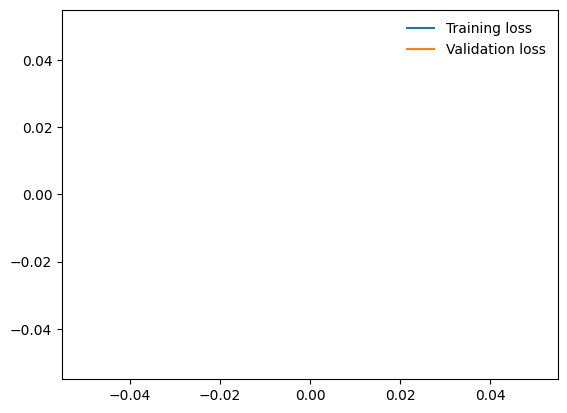

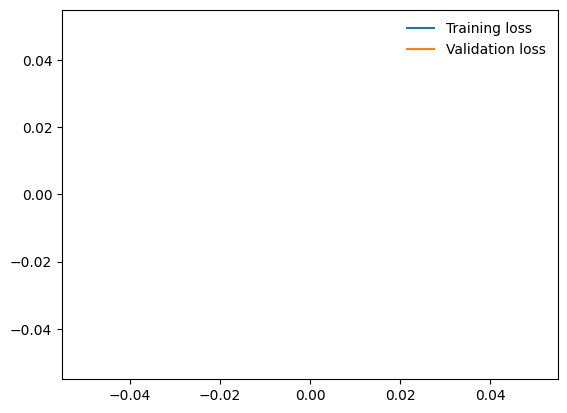

C:\Users\Aviv\AppData\Local\Temp\ipykernel_9228\3914365141.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("weights/weight_18.pt"))


Model Accuracy= 14.117647058823529  | avg error:3.433734893798828 | flips: 2 
 


C:\Users\Aviv\AppData\Local\Temp\ipykernel_9228\3914365141.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model50.load_state_dict(torch.load("weights/weight_50.pt"))


Model Accuracy= 10.588235294117647  | avg error:2.4000000953674316 | flips: 0 
 


In [39]:
train_data = OrientationMixDataset(train_dir, data_dir_real, transform=transform, max=-1)
test_data = OrientationDataset(valid_dir,transform=transform_tests)

valid_size = 0.15
# Split data into train and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data,batch_size=500,sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size =100, sampler=valid_sampler)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)

tn_loss, val_loss = train_model_func(f"weights/weight_18", train_loader, valid_loader)

plt.plot(tn_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)


plt.show()
tn_loss, val_loss = train_model_func(f"weights/weight_50", train_loader, valid_loader, use_50=True)
plt.plot(tn_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)


plt.show()

model = DegreeCNN().to(device)
model.load_state_dict(torch.load("weights/weight_18.pt"))
acc, err, flips = evaluate_model(model, test_loader)

model50 = DegreeCNN50().to(device)
model50.load_state_dict(torch.load("weights/weight_50.pt"))
acc, err, flips = evaluate_model(model50, test_loader)


In [40]:
test_data = OrientationDataset("test/output",transform=transform_tests)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)

model = DegreeCNN().to(device)
model.load_state_dict(torch.load("weights/weight_12500.pt"))
acc, err, flips = evaluate_model(model, test_loader)

C:\Users\Aviv\AppData\Local\Temp\ipykernel_9228\3077060697.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("weights/weight_12500.pt"))


Model Accuracy= 18.835616438356166  | avg error:1.9238014221191406 | flips: 0 
 


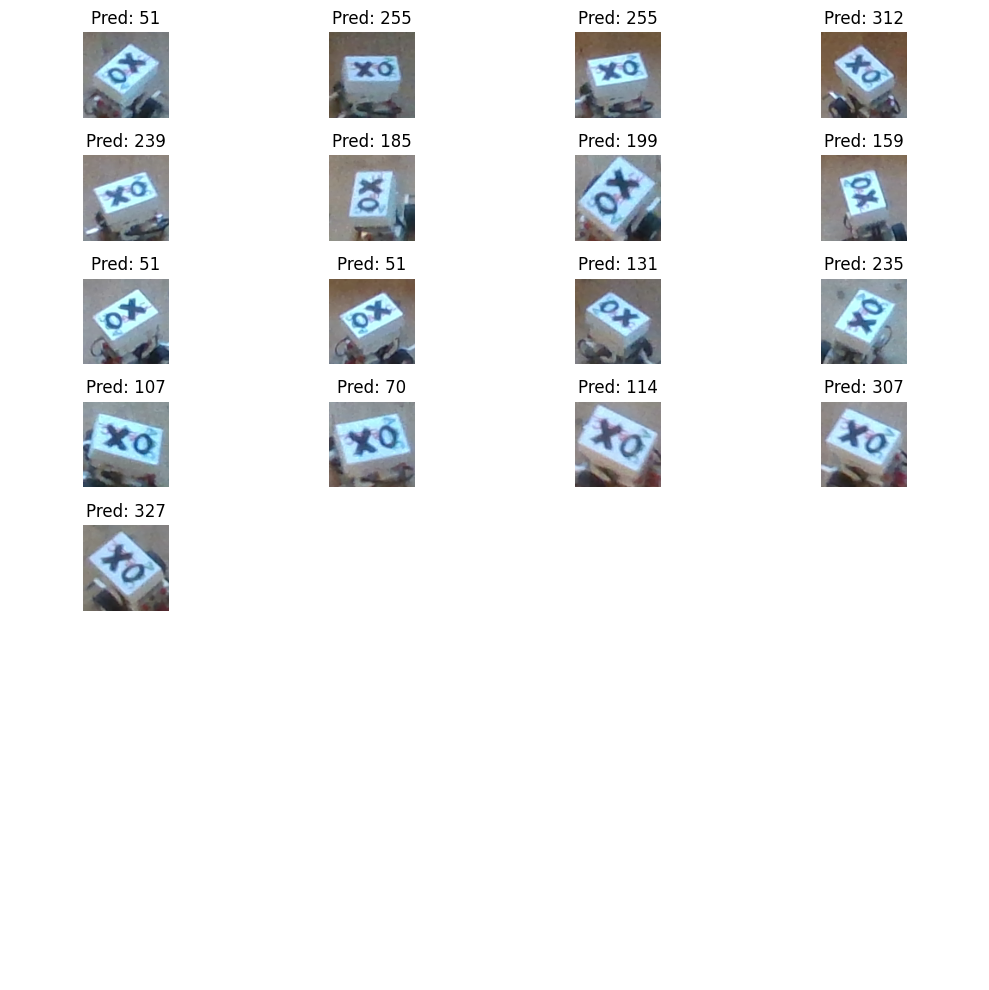

In [41]:
import glob
from PIL import Image, ImageEnhance

def plot_misclassified_images_grid(misclassified_images, misclassified_pred_labels, rows=2, cols=3):
    total_images = len(misclassified_images)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < total_images:
            ax.imshow(misclassified_images[i])  # Convert tensor to image
            ax.set_title(f"Pred: {misclassified_pred_labels[i]}")
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide empty subplots if images are fewer than grid spaces

    plt.tight_layout()
    plt.show()

image_list = []
for filename in glob.glob('test_or/*.png'):
    img = Image.open(filename).convert("RGB")
    # img = ImageEnhance.Color(img).enhance(2) 
    # img = ImageEnhance.Brightness(img).enhance(1.2)
    # img = ImageEnhance.Contrast(img).enhance(1.2)
    # img.show()
    image_list.append(img)
    
labels = []
for img in image_list:
    input = no_norm_transform_tests(img).unsqueeze(0).cuda()
    with torch.no_grad():
        output = model(input)
        _, predicted_idx = torch.max(output, 1)
        # print('Predicted class index:', predicted_idx.item())
        labels.append(predicted_idx.item())

plot_misclassified_images_grid(image_list, labels, 8, 4)

[1000, 2000, 3000, 4000, 5000, 8000, 10000, 12500, 15000, 20000, 25000]
[8.0, 9.1, 7.6, 8.6, 8.7, 11.7, 11.3, 12.7, 11.7, 12.2, 10.7]
[4.6, 4.9, 4.4, 4.4, 4.0, 3.1, 3.3, 3.6, 3.3, 2.4, 2.6]
[1.0, 0.3, 2.3, 0.0, 0.0, 0.7, 0.7, 0.0, 2.3, 0.3, 0.7]


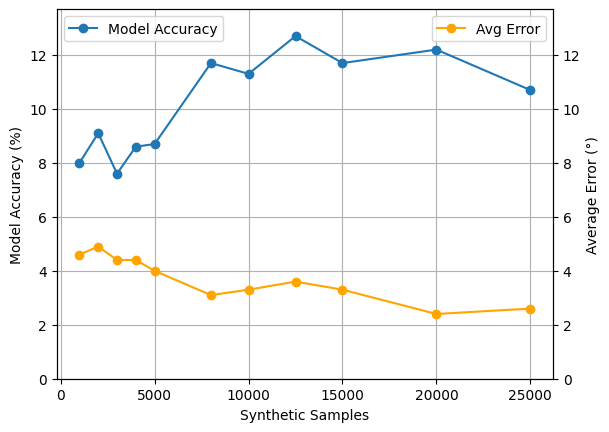

In [42]:
import matplotlib.pyplot as plt

# Data
samples = maxes
model_accuracy = [round(x[0], 1) for x in mix_data]
avg_error = [round(x[1].item(), 1) for x in mix_data]
print(maxes)
print(model_accuracy)
print(avg_error)
print([round(x[2], 1) for x in mix_data])
fig, ax1 = plt.subplots()

# Plot Model Accuracy
# ax1.figure(figsize=(8, 6))
ax1.plot(samples, model_accuracy, marker='o', label="Model Accuracy")
# ax1.title("Model Accuracy vs Synthetic Amount")
ax1.set_xlabel("Synthetic Samples")
ax1.set_ylabel("Model Accuracy (%)")
ax1.set_ylim(0, max(model_accuracy) + 1)  # Start y-axis at 0 and adjust max limit
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()  # Get all legend handles and labels
plt.legend(handles, labels, loc='upper left')           # Combine and display legend
# plt.show()

# Plot Avg Error
ax2 = ax1.twinx()
# ax2.figure(figsize=(8, 6))
ax2.plot(samples, avg_error, marker='o', color='orange', label="Avg Error")
# ax2.title("Average Error vs Synthetic Amount")
# ax2.set_xlabel("Synthetic Amount")
ax2.set_ylabel("Average Error (°)")
ax2.set_ylim(0, max(avg_error) + 1)  # Start y-axis at 0 and adjust max limit
ax2.set_ylim(ax1.get_ylim())  # Align Y-axis limits for grid alignment
ax2.yaxis.set_major_locator(ax1.yaxis.get_major_locator())  # Sync major gridlines
# plt.grid(True)
plt.legend()
plt.show()


# fine-tune training

[1000, 2000, 3000, 4000, 5000, 8000, 10000, 12500, 15000, 20000, 25000]
[5.3061, 5.7143, 9.3878, 10.6122, 13.4694, 13.8776, 11.0204, 12.6531, 9.3878, 13.0612, 12.6531]
[6.893, 15.4156, 4.8, 3.7388, 3.5224, 5.7265, 2.7633, 2.8041, 3.1347, 2.2286, 2.6041]


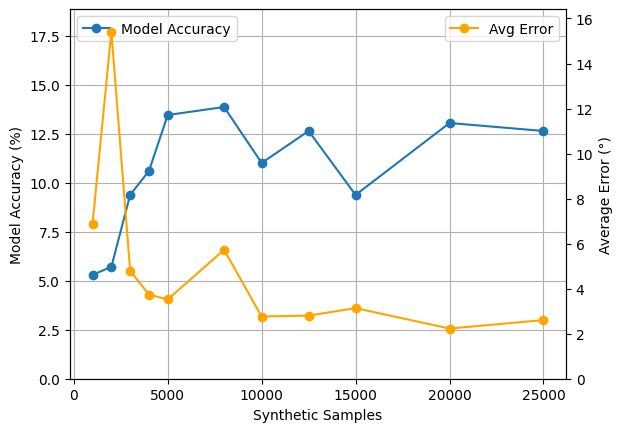

In [43]:
import matplotlib.pyplot as plt

# Data
samples = maxes
model_accuracy = [round(x[0], 4) for x in fin_data]
avg_error = [round(x[1].item(), 4) for x in fin_data]
print(maxes)
print(model_accuracy)
print(avg_error)

fig, ax1 = plt.subplots()

# Plot Model Accuracy
# ax1.figure(figsize=(8, 6))
ax1.plot(samples, model_accuracy, marker='o', label="Model Accuracy")
# ax1.title("Model Accuracy vs Synthetic Amount")
ax1.set_xlabel("Synthetic Samples")
ax1.set_ylabel("Model Accuracy (%)")
ax1.set_ylim(0, max(model_accuracy) + 5)  # Start y-axis at 0 and adjust max limit
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()  # Get all legend handles and labels
plt.legend(loc='upper left')           # Combine and display legend
# plt.show()

# Plot Avg Error
ax2 = ax1.twinx()
# ax2.figure(figsize=(8, 6))
ax2.plot(samples, avg_error, marker='o', color='orange', label="Avg Error")
# ax2.title("Average Error vs Synthetic Amount")
# ax2.set_xlabel("Synthetic Amount")
ax2.set_ylabel("Average Error (°)")
ax2.set_ylim(0, max(avg_error) + 1)  # Start y-axis at 0 and adjust max limit
# plt.grid(True)
plt.legend()
plt.show()